# Importation des bibliothéques utiles pour la suite

In [35]:
import matplotlib.pyplot as plt # Pour l'affichage des graphiques
import numpy as np
import pandas as pd

# Les modules pour les simulation
import ordinaryMC
import QMC
import MLMC

# Les modules pour les calculs et comparaisons
import calcul
import comparaison
import comparaison_CPU_fixe

# Importation des valeurs

In [4]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 
nb_samples = 100

# On conserve au maximum 1000, cependant pour certaines parties du projet à cause du temps de calcul max_sample pourra être réduit
max_sample = 1000

# Partie 1 : Monte Carlo Ordinaire

Le but de cette partie est de présenter la méthode monte carlo ordinaire avec :
- Le CIR 
- La simulation de Monte Carlo avec intervalles de confiance
- La valeur du prix que nous allons fixer pour la suite "mean_pv_payoffs_cvg"
- La valeur du CPU Time pour le nombre de trajectoires où l'on considére que ça converge
- La valeur des MSE pour différents nombres de trajectoires

# A) Test du CIR ordinaire

In [31]:
S = ordinaryMC.CIR(alpha, b, sigma, T, k, S_0)
#S1 = CIR.CIR_new(alpha, b, sigma, T/k, T, S_0)

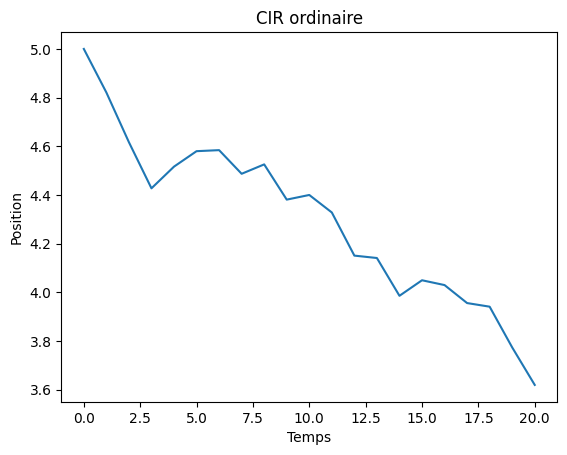

In [32]:
plt.plot(S)
#plt.plot(S1)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR ordinaire')
plt.show()

In [33]:
M = ordinaryMC.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

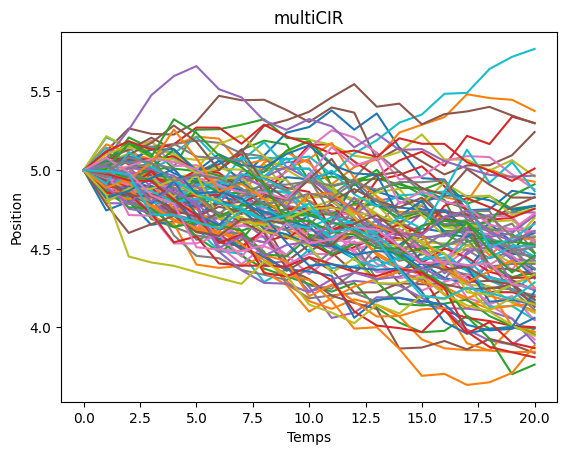

In [34]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# B) Simulation de Monte Carlo Ordinaire

In [35]:
calcul.pv_calc(M[3],r, T)

array([4.75614712, 4.7353705 , 4.83803372, 4.69591215, 4.63471876,
       4.48882447, 4.32333811, 4.34947286, 4.3200626 , 4.36388297,
       4.31214691, 4.37667696, 4.43423665, 4.40964506, 4.36293212,
       4.41734463, 4.47306255, 4.48719175, 4.32802137, 4.25898588,
       4.44125777])

In [36]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [37]:
# Première estimation de la valeur C recherchée
np.mean(OMC)

0.6804477705327493

In [38]:
# On estime la valeur C pour différentes tailles d'échantillons de 10 en 10
ordinaryMC_price_esitmates, ordinaryMC_CIs = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method='ordinary')

Price estimated at largest sample size with ordinary MC: 0.6786178143714319
CI length at largest sample size with ordinary MC: 0.028768094704400005


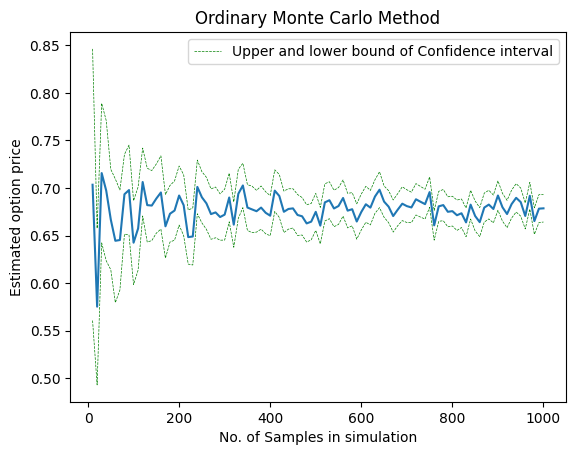

In [39]:
print("Price estimated at largest sample size with ordinary MC:", str(ordinaryMC_price_esitmates[-1]))
print("CI length at largest sample size with ordinary MC:", str(ordinaryMC_CIs[-1,1] - ordinaryMC_CIs[-1,0]))

#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinaryMC_price_esitmates)
plt.plot(x_axis1, ordinaryMC_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, ordinaryMC_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()


In [40]:
tol = 0.03
mc_threshold = comparaison.threshold_finder(ordinaryMC_CIs, tol)

81


In [41]:
if isinstance(mc_threshold, int) ==True :
    sample_convergent = mc_threshold * 10
    print("Le seuil que nous considérons comme être celui convergeznt sera donc par la suite :",sample_convergent)
else :
    print("Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand")


Le seuil que nous considérons comme être celui convergeznt sera donc par la suite : 810


# C) Comparaison Monte Carlo ordinaire pour des valeurs de nb_samples différetes

En réalité pour des problèmes de temps d'exécution nous allons prendre une simulation pour un nb_sample = 100 000, ce qui aurait prit trop de temps à exécuter de 10 en 10 précédemment

In [42]:
present_payoffs_cvg = ordinaryMC.ordinary_mc_sim(100000,k, S_0, T, r, sigma, K, alpha, b)
mean_pv_payoffs_cvg = np.mean(present_payoffs_cvg)
mean_pv_payoffs_cvg

0.6781245997555464

In [43]:
CPU_sample = comparaison.CPU(sample_convergent,k, S_0, T, r, sigma, K, alpha, b, method='ordinary')
CPU_sample


0.07261440000729635

In [44]:
max_sample_mse = 100
# Nous prenons 100 aussi pour des raisons de temps d'exécution, sinon vous pouvez mettre 1000 pour être cohérent avec le reste du projet
mse_values = comparaison.mse_comparaison(max_sample_mse, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='ordinary')

10
20
30
40
50
60
70
80
90
100


In [45]:
mse_values[0]

array([0.00498026, 0.00279181, 0.00196647, 0.00139942, 0.00104615,
       0.00084776, 0.00081105, 0.00073654, 0.00054625, 0.00045737])

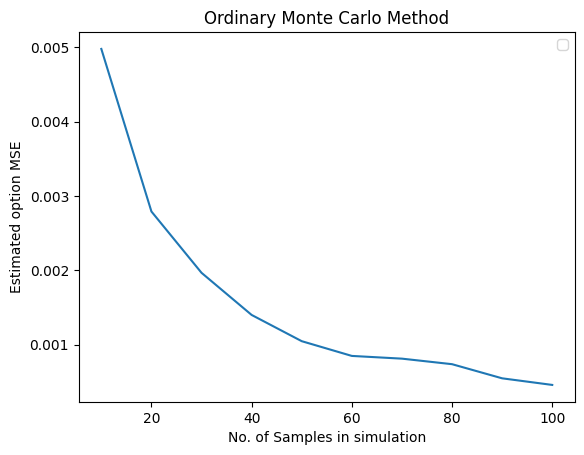

In [46]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values[0])
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option MSE")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

On obtient bien une courbe décroissante en la valeur des simulations, ce qui est ce qu'on voulait obtenir.

# Partie 2 : Quasi Monte Carlo

Le but de cette partie est de présenter la méthode quasi monte carlo et randomised quasi monte carlo avec :
- Le CIR généré avec Sobol pour une dimension d = 39
- La simulation du (randomised) quasi Monte Carlo avec intervalles de confiance
- La valeur du CPU Time pour le randomised quasi monte carlo avec le nombre de trajectoires où l'on considére que ça converge
- La valeur des MSE pour différents nombres de trajectoires

# A) Tests Sobol generator et QMC

In [47]:
sobol = QMC.sobol_generator(nb_samples, k)
print(sobol, len(sobol), len(sobol[1,]))

[[0.5     0.75    0.25    ... 0.84375 0.34375 0.46875]
 [0.5     0.25    0.75    ... 0.21875 0.71875 0.09375]
 [0.5     0.75    0.25    ... 0.09375 0.59375 0.46875]
 ...
 [0.75    0.25    0.875   ... 0.53125 0.15625 0.65625]
 [0.75    0.25    0.375   ... 0.09375 0.21875 0.71875]
 [0.75    0.25    0.125   ... 0.78125 0.65625 0.15625]] 117 20


On obtient bien une suite de sobol qui respecte les propriétés recherchées

In [48]:
M = QMC.multiCIR_QMC(alpha, b, sigma, T, k, S_0, nb_samples)

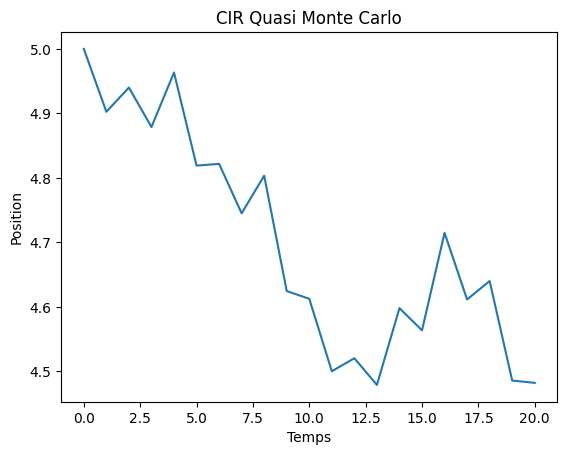

In [49]:
plt.plot(M[1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Quasi Monte Carlo')
plt.show()

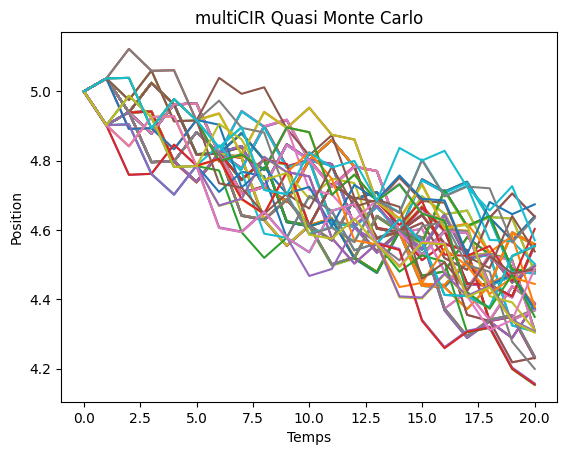

In [50]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR Quasi Monte Carlo')
plt.show()

In [51]:
calcul.pv_calc(M[3],r, T)

array([4.75614712, 4.66345079, 4.69914028, 4.56226408, 4.56486702,
       4.50807057, 4.58792692, 4.60631592, 4.49585464, 4.61115062,
       4.56896722, 4.55650063, 4.38662669, 4.44190474, 4.37079301,
       4.3235163 , 4.41775917, 4.2991677 , 4.31043676, 4.23279869,
       4.27786066])

In [52]:
OMC_QMC = QMC.QMC_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)
np.mean(OMC_QMC)

0.6729958803021122

In [53]:
sobol_price_esitmates, sobol_CIs = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method="QMC")

In [54]:
print("Price estimated at largest sample size with Sobol sequence:", str(sobol_price_esitmates[-1]))
print("CI length at largest sample size with Sobol sequence:", str(sobol_CIs[-1,1] - sobol_CIs[-1,0]))

Price estimated at largest sample size with Sobol sequence: 0.672063980448986
CI length at largest sample size with Sobol sequence: 0.009965255969321296


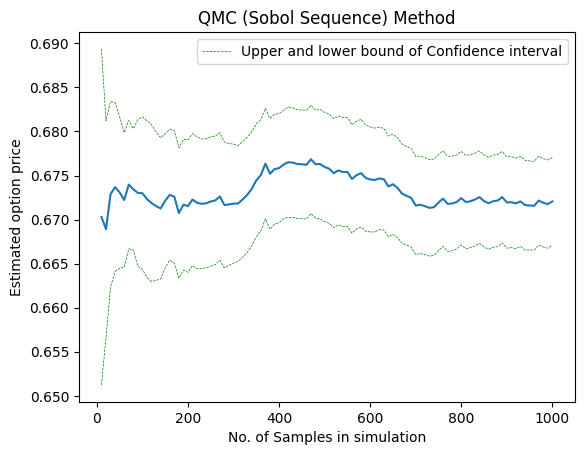

In [55]:
#Ploting quasi-Monte Carlo method using Sobol sequence
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, sobol_price_esitmates)
plt.plot(x_axis1, sobol_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol Sequence) Method")
plt.legend()
plt.show()

In [56]:
sobol_threshold = comparaison.threshold_finder(sobol_CIs, tol)

1


In [57]:
if isinstance(sobol_threshold, int) ==True :
    sample_convergent_QMC = sobol_threshold * 10
    print("Le seuil que nous considérons comme être celui convergeznt sera donc par la suite :",sample_convergent_QMC)
else :
    print("Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand")

Le seuil que nous considérons comme être celui convergeznt sera donc par la suite : 10


# B) QMC random

In [58]:
sobol_price_esitmates_random, sobol_CIs_random = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')


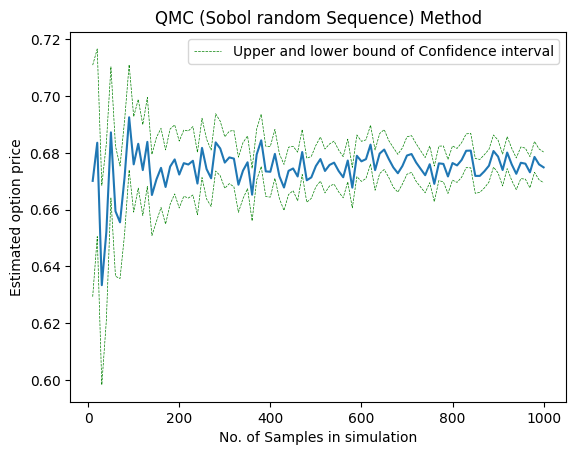

In [59]:
#Ploting quasi-Monte Carlo method using Sobol sequence
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, sobol_price_esitmates_random)
plt.plot(x_axis1, sobol_CIs_random[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs_random[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol random Sequence) Method")
plt.legend()
plt.show()

# C) Comparaison QMC randomised

La comparaison est uniquement faites avec le QMC random car elle n'aurait pas de sens avec QMC étant une technique déterministe

In [60]:
mean_pv_payoffs_cvg 
# On garde le même que pour l'ordinaire

0.6781245997555464

In [61]:
CPU_sample_QMC = comparaison.CPU(sample_convergent_QMC,k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')
CPU_sample_QMC

0.003840599994873628

In [62]:
# max_sample_mse = 100
mse_values_QMC = comparaison.mse_comparaison(max_sample_mse, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='QMC_random')


10
20
30
40
50
60
70
80
90
100


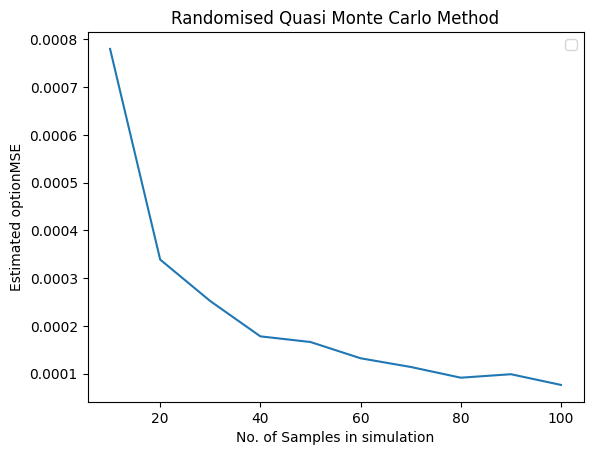

In [63]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values_QMC[0])
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated optionMSE")
plt.title("Randomised Quasi Monte Carlo Method")
plt.legend()
plt.show()

# Partie 3: Multi Level CIR

Le but de cette partie est de présenter la méthode multi-level monte carlo ordinaire avec :
- Le CIR multilevel 
- La simulation du multi level Monte Carlo
- Le reste des analyses à CPU Time fixé sera dans la Partie 4

# A) Test du CIR multilevel

In [16]:
L = 5
S = MLMC.CIR_ML(alpha, b, sigma, L, T, S_0)
S

(array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
        0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
        0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 array([5.        , 5.04283264, 5.02108787, 5.02146796, 5.14923146,
        5.11122351, 5.08342321, 5.14560331, 5.0597926 , 5.13909547,
        5.05650782, 5.15741374, 5.23906488, 5.0978488 , 5.04337218,
        5.10166306, 4.98331014, 4.97683434, 5.01323182, 5.09723624,
        5.16640493, 5.12882656, 4.98850661, 4.97354861, 4.83448016,
        4.59089199, 4.47723964, 4.25003809, 4.16812455, 4.22727756,
        4.40433742, 4.27606399, 4.31445064]))

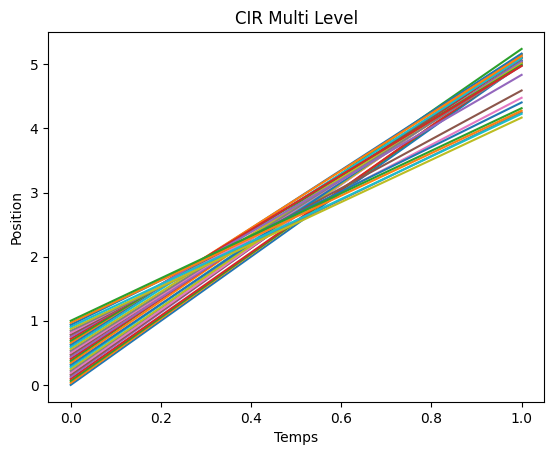

In [17]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [19]:
M = MLMC.multiCIR_ML(alpha, b, sigma, L, T, S_0, nb_samples)
M

[[(array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
          0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
          0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
          0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
          0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
   array([5.        , 5.056675  , 5.1510394 , 5.20018834, 5.24600774,
          5.16618937, 5.08747284, 5.11413595, 5.0536882 , 5.1492213 ,
          5.20850136, 5.10491262, 5.06290597, 5.00342073, 5.0181632 ,
          5.01611189, 4.89753392, 4.75102326, 4.56962332, 4.62676296,
          4.55887543, 4.56320303, 4.68869658, 4.55125979, 4.6474687 ,
          4.74424963, 4.7782751 , 4.69635309, 4.79787912, 4.74445134,
          4.8257448 , 4.90888463, 4.97697643])),
  ([0.0,
    0.0625,
    0.125,
    0.1875,
    0.25,
    0.3125,
    0.375,
    0.4375,
    0.5,
    0.5625,
    0.625,
    0.6875,
    0.75,
    0.8125,
    0.875,
    0.9375,
    

In [18]:
multiCIR=[]
M = MLMC.CIR_ML(alpha, b, sigma, 1/100, T, S_0)
multiCIR.append(M)


In [20]:
for j in range(3): 
    A = ([multiCIR[j][0][i] for i in range(0,len(multiCIR[j][0])+1,2)],[multiCIR[j][1][i] for i in range(0,len(multiCIR[j][0])+1,2)])
    multiCIR.append(A)

IndexError: list index out of range

In [83]:
multiCIR

[(array([0.        , 0.9930925 , 1.98618499]),
  array([5.        , 4.31625725, 4.38943822])),
 ([0.0, 1.9861849908740719], [5.0, 4.3894382176577444])]

In [80]:
for i in range(10):
    plt.plot(multiCIR[i][0],multiCIR[i][1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

NameError: name 'multiCIR' is not defined

In [ ]:
zap = CIR.CIR(alpha, b, sigma, T, k, S_0)
zap2 = CIR.CIR_ML(alpha, b, sigma, T, k, S_0,5)

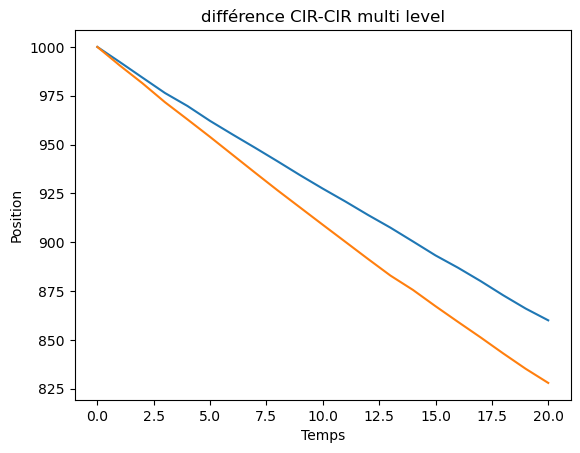

In [ ]:
plt.plot(zap)
plt.plot(zap2)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('différence CIR-CIR multi level')
plt.show()

# B) Simulation de Monte Carlo Multilevel

Le ordinary tu fais n fois avec la même dicrétisation alors que le multi level tu fais n fois mais avec des discrétisations de plus en plus fines. Et en plus c'est "gratuit" car on utilise le même mouvement brownien.

In [84]:
test=MLMC.multiCIR_ML(alpha, b, sigma, 3, T, S_0, 3)

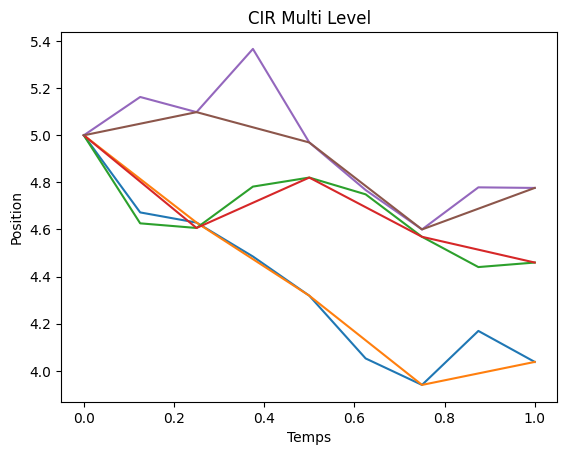

In [85]:
for i in range(3): #nb_sample
    plt.plot(test[i][0][0],test[i][0][1])
    plt.plot(test[i][1][0],test[i][1][1])


plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [86]:
MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b) #return y_chap, L, N, variances, means

(0.6586991676452245,
 3,
 [91560, 41911, 30234, 18205],
 array([0.04529482, 0.00525481, 0.00197333, 0.00065609]),
 array([ 0.66515632, -0.00347413, -0.00180759, -0.00117543]))

In [11]:
max_sample = 100
MLMC_price_esitmates, MLMC_CIs = calcul.sim_iterator(10, k, S_0, T, r, sigma, K, alpha, b, method='MLMC')

In [13]:
MLMC_price_esitmates

array([0.])

Price estimated at largest sample size with MLMC: 0.0


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

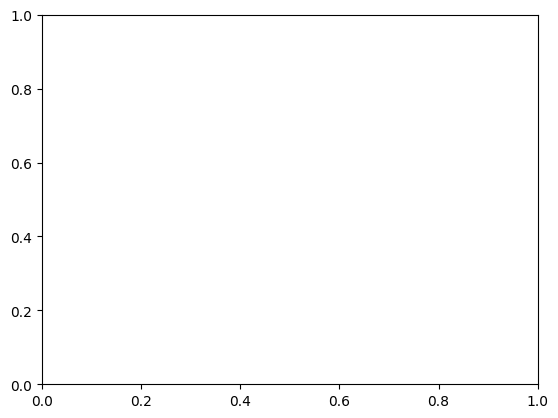

In [12]:
print("Price estimated at largest sample size with MLMC:", str(MLMC_price_esitmates[-1]))

#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, MLMC_price_esitmates)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Multilevel Monte Carlo Method")
plt.legend()
plt.show()

# Partie 4 : Comparaison des intervalles de confiance, CPU Time optimal et MSE pour des nb_samples différents

# A) Intervalles de confiance

In [65]:
ordinary_CI_lengths = comparaison.CI_length_calc(ordinaryMC_CIs)
sobol_CI_lengths = comparaison.CI_length_calc(sobol_CIs)
sobol_CI_lengths_random = comparaison.CI_length_calc(sobol_CIs_random)

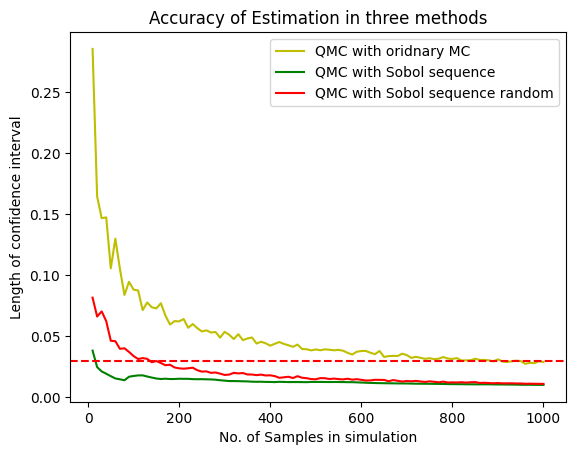

In [66]:
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinary_CI_lengths, 'y', label="QMC with oridnary MC")
plt.plot(x_axis1, sobol_CI_lengths, 'g', label="QMC with Sobol sequence")
plt.plot(x_axis1,sobol_CI_lengths_random, 'r', label="QMC with Sobol sequence random")


tol = 0.03
plt.axhline(tol, ls='--', c='r')
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Length of confidence interval")
plt.title("Accuracy of Estimation in three methods")
plt.legend()
plt.show()

# B) CPU Time

In [67]:
print("Le CPU Time de ordinary est :", CPU_sample)
print("Le CPU Time du quasi monte carlo randomised est :", CPU_sample_QMC)

Le CPU Time de ordinary est : 0.07261440000729635
Le CPU Time du quasi monte carlo randomised est : 0.003840599994873628


# C) MSE

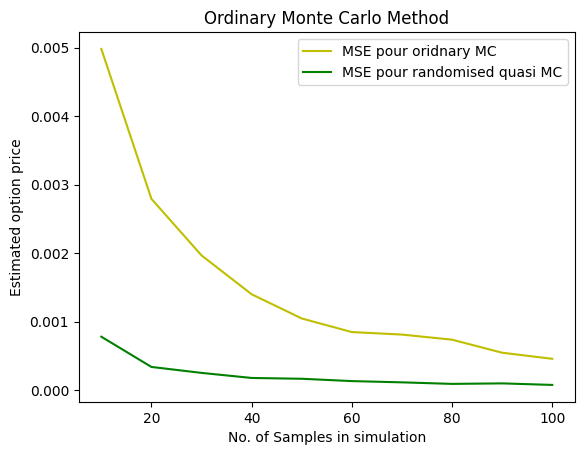

In [68]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values[0], 'y', label="MSE pour oridnary MC")
plt.plot(x_axis1, mse_values_QMC[0], 'g', label="MSE pour randomised quasi MC")
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

# D) Conclusion

# Partie 5 : Comparaison des MSE à CPU Time fixés

# A) Multi-level Monte Carlo

In [39]:
temps_comparaison = comparaison.CPU(None, k, S_0, T, r, sigma, K, alpha, b, method='MLMC')
temps_comparaison

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


7.486484199995175

Nous avons trouvé le CPU Time que mets Multi-level Monte Carlo pour le comparer à d'autres méthodes

In [ ]:
mean_pv_payoffs_cvg = 0.6781245997555464
mse_MLMC_time = comparaison.mse_time(0, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='MLMC')
mse_MLMC_time

0.00032960599519675206

# B) Ordinary Monte Carlo

In [ ]:
time_cvg_ordinary = comparaison.CPU(50000, k, S_0, T, r, sigma, K, alpha, b, method='ordinary')
time_cvg_ordinary

In [ ]:
temps_comparaison = 5.585382400022354
temps_ordinary = comparaison.CPU_comparaison(60000, 60100, temps_comparaison, k, S_0, T, r, sigma, K, alpha, b, method='ordinary')

KeyboardInterrupt: 

In [13]:
mean_pv_payoffs_cvg = 0.6781245997555464
mse_ordinary_time = comparaison.mse_time(55000, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='ordinary')
mse_ordinary_time

1.7028665503048618e-06

# C) Randomised Quasi Monte Carlo

In [15]:
time_cvg_RQMC = comparaison.CPU(20000, k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')
time_cvg_RQMC

6.757070799998473

In [ ]:
temps_comparaison = 5.585382400022354
temps_ordinary = comparaison.CPU_comparaison(60000, 60100, temps_comparaison, k, S_0, T, r, sigma, K, alpha, b, method='ordinary')

In [23]:
mean_pv_payoffs_cvg = 0.6781245997555464
mse_RQMC_time = comparaison.mse_time(20000, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='QMC_random')
mse_RQMC_time

7.679081013598257e-06

# D) Conclusion

In [37]:
data = [[temps_comparaison,time_cvg_ordinary,time_cvg_RQMC],[mse_MLMC_time, mse_ordinary_time, mse_RQMC_time]]
df = pd.DataFrame(data, columns=['CPU Time', 'MSE associés au CPU Time'])


NameError: name 'time_cvg_ordinary' is not defined